In [1]:
import math

def sim_config_init(game_type= 'fear', lgr=(10,1.1,0.5), num_bots=20, game_length=1000, decimals = 2, #basic setup
                    initialization_dist = 'NE', #initialization, can be 'NE', 'NE_support', 'uniform', 'normal'
                    initialization_range = (1,2), # if 'uniform' set the range; if 'normal', set mean and std
                    move_percent = 0.1, 
                    payoff_multiplier=1, payoff_deduction=40,
                    trembling_dist='uniform', trembling_range=(1,2),  
                    leaving_function='distance',
                     outlier_index_set=[1,3],  ):
    '''
    Specify simulation configuration parameters
    :param game_type: string, game type
    :param lgr: tuple, (lambda, gamma, rho), default to (10,1.1,0.5)
    :param num_bots: int, number of bots, default to 20
    :param game_length: int, game length, default to 1000
    :param trembling: float, trembling range, default to 0, trembles in jump destination
    :param xrange: tuple, strategy range
    :return: config, dictionary containing all simulation configuration parameters
    '''

    config = {}

    ##basic setup## 
    # game type: could be 'fear', 'greed'
    config['game_type'] = game_type

    # lambda/gamma/rho params
    config['lambda'] = lgr[0]
    config['gamma'] = lgr[1]
    config['rho'] = lgr[2]
    
    # based on gamma and rho, override game type
    if (config['game_type'] != 'other') and (config['gamma'] >= (config['rho'] + 4/3)):
        config['game_type'] = 'greed'
    elif (config['game_type'] != 'other') and (config['gamma'] <= (config['rho'] + 2/3)):
        config['game_type'] = 'fear'
        
    # decimals
    config['decimals'] = decimals

    # NE support 
    if config['game_type'] == 'fear':
        config['NE_support_min'] = max(0, round((config['lambda'] - math.sqrt(1+config['lambda']**2) * math.sqrt(1-(16*(1+config['rho'])*(config['gamma']-1))/((config['gamma'] +3*config['rho'])*(3*config['gamma'] +config['rho'])))),config['decimals']))
        config['NE_support_max'] = config['lambda']
    elif config['game_type'] == 'greed':
        config['NE_support_min'] = config['lambda']
        config['NE_support_max'] = round(config['lambda'] + math.sqrt(1+config['lambda']**2)/(math.sqrt(1+16*config['rho']*config['gamma']/((3*config['gamma']-3*config['rho']-2)*(config['gamma']-config['rho']+2)))), config['decimals'])


    # number of bots
    config['num_bots'] = num_bots
 
    # game length
    config['game_length'] = game_length
    

    
    ##initialization## -- how does the game start
    # initialization, can be 'NE', 'NE_support', 'uniform', 'normal'
    config['initialization_dist'] = initialization_dist
 
    # initialization range: if 'uniform' set the range; if 'normal', set mean and std
    config['initialization_range'] = initialization_range    
    
    
    ##landscape bound
    # x bound
    if config['game_type'] == 'fear':
        config['xmin'] = max(0 , config['NE_support_min']-2)
        config['xmax'] = config['NE_support_max'] + 3
    elif config['game_type'] == 'greed':
        config['xmin'] = max(0 , config['NE_support_min']-3)
        config['xmax'] = config['NE_support_max'] + 2
 

    # manipulate simulation similar to human experiment
    # landscape multiplys a number
    config['payoff_multiplier'] = payoff_multiplier
    
    # shifts landscape down by a value
    config['payoff_deduction'] = payoff_deduction

    
    ## trembling (noise)
    # trembling distribution: could be 'normal', 'uniform', 'triangular'
    config['trembling_dist'] = trembling_dist
    
    # trembling range
    config['trembling_range'] = trembling_range
    
    #leaving function type: distance; endogenous; replicator
    config['leaving_function'] = leaving_function    
    
    
    # move percentage
    config['move_percent'] = move_percent
    

    #index of outliers
    config['outlier_index_set'] = outlier_index_set   
    

    

    
    return config

In [2]:
import random
import numpy as np
import pandas as pd

def initialize_strategies(config):
    '''
    Function to run first simulation step to initialize each player's initial strategy
    :param config: dict, dictionary contains simulation parameters
    :return: array, initial strategies 
    '''
    # game type for starting distribution: set to fear or greed for respective distributions
    # these calculations are inexact because we have a finite number of players

    game_type = config['game_type']
    num_bots = config['num_bots']
    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    NE_support_min = config['NE_support_min']
    NE_support_max = config['NE_support_max']
    initialization = config['initialization_dist']
    decimals = config['decimals']

    strategies = []

    ## initialization starts from NE: theoritical prediction
    if initialization == 'NE':
        if game_type == 'fear':
            NE_support_x = np.round(np.arange(NE_support_min, NE_support_max, 1/(10**decimals)), decimals)
            # according to theory
            NE_support_cdf = gam - rho + np.sqrt((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * NE_support_x - NE_support_x ** 2))
            NE_support_cdf = np.nan_to_num(NE_support_cdf) #convert nan to 0
            NE_support_cdf = NE_support_cdf/2
            cdf_ind = 0
            for i in range(num_bots):
            # cdf_ind is the index in the cdf to compare to
            # we increment it until it is greater than or equal to the percentage of players set so far
                if (i+1)/num_bots <= NE_support_cdf[cdf_ind]:
                    strategies.append(NE_support_x[cdf_ind])
                else:
                    while cdf_ind < len(NE_support_cdf) - 1 and (i+1)/num_bots > NE_support_cdf[cdf_ind]:
                        cdf_ind = cdf_ind + 1
                    # there are some rounding issues when we reach the end of the cdf
                    # if we reach the end (for the last few players), just use the last value
                    if cdf_ind >= len(NE_support_cdf):
                        strategies.append(NE_support_x[len(NE_support_cdf)])
                    else:
                        strategies.append(NE_support_x[cdf_ind])
            strategies = np.array(strategies)
                        
        elif game_type == 'greed':
            NE_support_x = np.round(np.arange(NE_support_min, NE_support_max, 1/(10**decimals)), decimals)
            NE_support_cdf = gam - rho - np.sqrt((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2) / (1 + 2 * lam * NE_support_x - NE_support_x ** 2))
            NE_support_cdf = np.nan_to_num(NE_support_cdf) #convert nan to 0
            NE_support_cdf = NE_support_cdf / 2
            cdf_ind = len(NE_support_cdf) - 1
            i = num_bots
            while i > 0:
                # cdf_ind is the index in the cdf to compare to
                # we decrement it until it is less than or equal to the percentage of players set so far
                if (i-1)/num_bots >= NE_support_cdf[cdf_ind]:
                    strategies.append(NE_support_x[cdf_ind])
                else:
                    while cdf_ind > 0 and (i-1)/num_bots < NE_support_cdf[cdf_ind]:
                        cdf_ind = cdf_ind - 1
                    # there are some rounding issues when we reach the end of the cdf
                    # if we reach the end (for the last few players), just use the last value
                    if cdf_ind == 0:
                        strategies.append(NE_support_x[0])
                    else:
                        strategies.append(NE_support_x[cdf_ind])
                i = i - 1
            strategies = np.array(strategies)
                
    ## initialization starts from NE support: uniform distrubution within NE support         
    elif initialization == 'NE_support':
        strategies = np.random.uniform(NE_support_min, NE_support_max, num_bots)
            
    elif initialization == 'uniform': 
        initialization_range_min = config['initialization_range'][0]
        initialization_range_max = config['initialization_range'][1]
        strategies = np.random.uniform(initialization_range_min, initialization_range_max, num_bots)
        
    elif initialization == 'normal': 
        initialization_range_mean = config['initialization_range'][0]
        initialization_range_std = config['initialization_range'][1]
        strategies = np.random.normal(initialization_range_mean, initialization_range_std, num_bots)
        
    strategies = np.round(strategies, decimals)
    strategies = np.sort(strategies)
            
    initial_strategies = strategies.copy()

    return strategies, initial_strategies



#########################
def get_position(n, strategies, config):
    '''

    :param n: float, timing/location n
    :param strategies: array, current strategies
    :param config: dict, dictionary containing simulation parameters
    :return: float, position for timing n
    '''
    # positions are approximated more accurately by adding 0 to the value for greed and 1 for fear game
    if config['game_type'] == 'fear':
        pos = len([strat for strat in strategies if n > strat]) + 1
    elif config['game_type'] == 'greed':
        pos = len([strat for strat in strategies if n > strat])
    return pos

# Returns ties at timing n
def get_tie(n, strategies, config):
    '''
    :param n: float, timing n
    :param strategies: array, current strategies
    :param config: dict, dictionary containing simulation parameters
    :return: float, ties for timing n
    '''
    decimals = config['decimals'] 
    # this is only here to fix rounding comparison issues
    n = round(n,decimals)

    tie = 0
    # compare to strategies to calculate position
    tie = len([strat for strat in strategies if n == round(strat, decimals)])
    return tie



def calculate_payoff(config, strategies):
    '''
    calculate payoff at every x at period 0
    :param config: dict, dictionary contains simulation parameters
    :param strategies: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :return: x: array of possible x; y: array of payoff given timing x; strat_x: sorted strategies from low to high;
             strat_y: array of payoffs given sorted strategies; strategies_y: array of payoffs given strategies
    '''
    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    xmin = config['xmin']
    xmax = config['xmax']
    decimals = config['decimals']
    payoff_multiplier = config['payoff_multiplier']
    payoff_deduction = config['payoff_deduction']
    # set the array of possible x values
    x = np.round(np.arange(xmin, xmax, 1/10**decimals),decimals)
    positions = []
    ties = []
    # set up values for landscape positions and ties
    for val in x:
        positions.append(get_position(val, strategies, config))
        ties.append(get_tie(val, strategies, config))
    positions = np.array(positions)
    # calculate timing component
    ux = 1 + (2 * lam * x) - (x * x)
    vy = []
    quantile = []
    # calculate positional component, including ties
    for i in range(len(positions)):
        if ties[i] == 0:
            vy.append((1 - (positions[i]/len(strategies))/gam) * (1 + (positions[i]/len(strategies))/rho))
            quantile.append(positions[i]/len(strategies))
        else:
            total = 0
            total_quantile = 0
            for j in range(ties[i]):
                total += (1 - ((positions[i]+j)/len(strategies))/gam) * (1 + ((positions[i]+j)/len(strategies))/rho)
                total_quantile += (positions[i])/len(strategies)
            total = total/ties[i]
            vy.append(total)
            total_quantile = total_quantile/ties[i]
            quantile.append(total_quantile)
            
    quantile = np.array(quantile)
    if config['game_type'] == 'fear':
        quantile = quantile - 1/config['num_bots']
    elif config['game_type'] == 'other':
        quantile = quantile - 0.5/config['num_bots']    
        
    y = ux * vy*payoff_multiplier - payoff_deduction
    strategies_y = []
    bubble = []
    # calculate bubble positions
    for strat in strategies:
        strat = round(strat,decimals)
        indice = np.where(x == strat)[0] #reduce running time b 90%
        bubble.append(y[indice][0])
#         print(strat, indice, y[indice])
#         bubble.append(get_y(strat, strategies, config))
    return x, y, quantile, bubble


# Loops through all players and moves them if they are ready to move
def update_strategies_unpurified(x, y, strategies, bubble, config):
    '''
    :param x: numpy array, array of possible x
    :param y: numpy array, payoff array w.r.t each element in x
    :param strategies: list, list containing previous strategies of each player
    :param config: dict, dictionary containing simulation parameters
    :return: strategies: list, list containing updated strategies of each player
    '''
    trembling_range = config['trembling_range']
    trembling_dist = config['trembling_dist']
    move_size = round(config['move_percent'] *config['num_bots'])
    static_strategies = strategies.copy()
    outlier_index_set = config['outlier_index_set']
    NE_support_min = config['NE_support_min']
    NE_support_max = config['NE_support_max']
    xmin = config['xmin']
    xmax = config['xmax']
    game_type = config['game_type']
    
    best_possible = max(y)
    players_index = list(range(len(strategies)))
    
    ###random
    # random choose n players to move
    if config['leaving_function'] == 'random':
        selected_player_index = random.sample(players_index, move_size)
    
    # jump frequencies proportional to regret
    elif config['leaving_function'] == 'distance_proportional':
        zeta = 4
        distances_from_best_payoff = abs(bubble-best_possible)
        distances_from_best_payoff = np.round(distances_from_best_payoff, decimals=2)
        ## add zeta
        distances_from_best_payoff = np.round(distances_from_best_payoff**zeta, decimals=2)
        n=0
        selected_player_index = set([])
        while n < move_size:
            chosen_one = random.choices(players_index, weights=distances_from_best_payoff,k=1)
            selected_player_index.update(chosen_one)
            index = players_index.index(chosen_one[0])
            del players_index[index]
            distances_from_best_payoff = np.delete(distances_from_best_payoff, index)
            n+=1
            sum_weights = math.fsum(distances_from_best_payoff)
            if sum_weights == 0:
                break
        if len(selected_player_index) != move_size:
            remaining = random.sample(players_index,k=move_size-n)
            selected_player_index.update(remaining)

    # players with the most n gain move
    elif config['leaving_function'] == 'distance_most_gain':
        distances_from_best_payoff = abs(bubble-best_possible)
        # Get indices of the first n largest values
        selected_player_index = np.argsort(-distances_from_best_payoff)[:move_size]
        
            
    ###arriving function

    for i in selected_player_index:
    # find best payoff index
        index = i  
        indices = [k for k, j in enumerate(y) if j == best_possible]
        best_choice = random.choice(indices)
        best_choice = x[best_choice]                


#         if best_choice == static_strategies[index]:    
#             strategies[i] = best_choice
# #                 strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2)
#         else:
#             if trembling_dist == 'uniform':
#                 strategies[i] = best_choice + np.random.uniform(trembling_range[0], trembling_range[1], 1)[0]
#             elif trembling_dist == 'normal':
#                 strategies[i] = best_choice + np.random.normal(trembling_range[0], trembling_range[1], 1)[0]
#             elif trembling_dist == 'triangular':
#                 strategies[i] = best_choice + np.random.triangular(-trembling_range[1],trembling_range[0],trembling_range[1], 1)
#             elif trembling_dist == 'None':
#                 strategies[i] = best_choice

        if trembling_dist == 'uniform':
            strategies[i] = best_choice + np.random.uniform(trembling_range[0], trembling_range[1], 1)[0]
        elif trembling_dist == 'normal':
            strategies[i] = best_choice + np.random.normal(trembling_range[0], trembling_range[1], 1)[0]
        elif trembling_dist == 'triangular':
            strategies[i] = best_choice + np.random.triangular(-trembling_range[1],trembling_range[0],trembling_range[1], 1)
        elif trembling_dist == 'None':
            strategies[i] = best_choice
        
    strategies = np.round(strategies, 2)


#                 if game_type == 'fear':
# #                     strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2) + round((random.random() * 0.3 - 0.3), 2)*config['uneven']
#                     strategies[i] = best_choice + np.random.normal(0, trembling, 1)[0]
#                 elif game_type == 'greed':
# #                     strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2) + round((random.random() * 0.3 - 0), 2)*config['uneven']
#                    strategies[i] = best_choice + np.random.normal(0, trembling, 1)[0]
#         if i in outlier_index_set:
#             strategies[i] = round(random.random() * (cdfmax - cdfmin) + cdfmin, 2)
#         print(strategies)
###########################################        
  
    
    return strategies, selected_player_index


In [3]:
cd './cycles/sim_data/'

/Users/weinan/Documents/GitHub/oTreeProjects/TimingGames2024/cycles/sim_data


----------------Simulation Start----------------
Period 0 done
Period 20 done
Period 40 done
Period 60 done
Period 80 done
Period 100 done
Period 120 done
Period 140 done
Period 160 done
Period 180 done
Period 200 done
Period 220 done
Period 240 done
Period 260 done
Period 280 done
Period 300 done
Period 320 done
Period 340 done
Period 360 done
Period 380 done
Period 400 done
Period 420 done
Period 440 done
Period 460 done
Period 480 done
Period 500 done
Period 520 done
Period 540 done
Period 560 done
Period 580 done
Period 600 done
Period 620 done
Period 640 done
Period 660 done
Period 680 done
Period 700 done
Period 720 done
Period 740 done
Period 760 done
Period 780 done
Period 800 done
Period 820 done
Period 840 done
Period 860 done
Period 880 done
Period 900 done
Period 920 done
Period 940 done
Period 960 done
Period 980 done
Period 1000 done
Period 1020 done
Period 1040 done
Period 1060 done
Period 1080 done
Period 1100 done
Period 1120 done
Period 1140 done
Period 1160 done
Peri

<IPython.core.display.Javascript object>


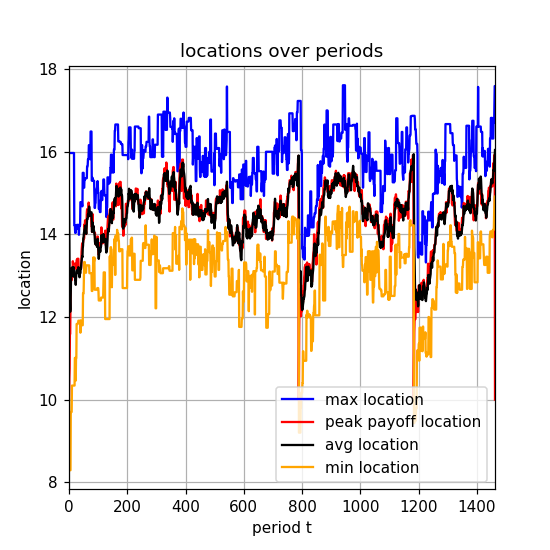

In [9]:
from datetime import datetime
from PIL import Image
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
%matplotlib notebook

################one game for testing########################

# main_folder = 'one_shot_NE/'
# rho_values = [0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 10, 20, 50, 100, 500, 1000]
# gam_minus_rho = np.array(
#    [ -4, -3, -2, -1, 0, #fear w/o rush
#     0.1, 0.2, 0.3, 0.4, 0.5, 0.6, #fear w/ rush
#     0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, #two eqm: fear
#     0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, #two eqm: greed
#     1.4, 1.5, 1.6, 1.7, 1.8, 1.9, #greed w/ rush
#     2, 3, 4, 5, 6] #greed w/o rush
# )
# game_types = ['fear']*18+['greed']*18



# para_folder = ['greed_wo_rush_']
# para_trembling = [0.03]
# para_game_length = [300]
# para_move = [0.2]



# for para in range(len(para_trembling)):
start=datetime.now()
history = {}
round_idx = 0
history_round = []
history_peak_payoff_location = []
history_peak_payoff_count = []
history_max_location = []
history_min_location = []
history_mean_location = []
history_median_location = []
cycle_start_round_number = []
# tunnel_location = [] # document the avg return location for all the first jumpers in one cycle
# farest_location_away_harvest = [] # document the avg farest location that is away from harvest at each cycle start
# avg_location_end_cycle = [] # document the avg location of all bots just before jumping

# Set up simulation configuration
#####################################
sim_config = sim_config_init(
    game_type= 'greed', 
    lgr=(10,2,0.5), 
    num_bots=20, 
    game_length=2000, 
    decimals = 2,
    initialization_dist = 'NE', #initialization, can be 'NE', 'NE_support', 'uniform', 'normal'
    initialization_range = (1,2), # if 'uniform' set the range; if 'normal', set mean and std
    move_percent = 0.2, 
    trembling_dist='normal', #normal or None or uniform or triangular
    trembling_range=(0,0.7), 
    leaving_function='random', #random or distance_proportional, distance_most_gain
    outlier_index_set=[],  
    payoff_multiplier=1, 
    payoff_deduction=0,
)
# if sim_config['trembling_dist'] == 'normal':
#     folder_name = para_folder[para] + str(sim_config['game_type']) + '_'+'bots'+str(sim_config['num_bots'])+'_leaving_' + sim_config['leaving_function'] + '_move'+ str(sim_config['move_percent'])+'_trembling_' + sim_config['trembling_dist'] + str(sim_config['trembling_range'][1]) + '/'
# elif sim_config['trembling_dist'] == 'None':
#     folder_name = para_folder[para] + str(sim_config['game_type']) + '_'+'bots'+str(sim_config['num_bots'])+'_leaving_' + sim_config['leaving_function'] + '_move'+ str(sim_config['move_percent'])+'_trembling_' + sim_config['trembling_dist'] + '/'
# elif sim_config['trembling_dist'] == 'uniform':
#     folder_name = para_folder[para] + str(sim_config['game_type']) + '_'+'bots'+str(sim_config['num_bots'])+'_leaving_' + sim_config['leaving_function'] + '_move'+ str(sim_config['move_percent'])+'_trembling_' + sim_config['trembling_dist'] + str(sim_config['trembling_range'][1]) + '/'
# # NE support
#     print(folder_name)
#     break
NE_support_min = sim_config['NE_support_min']
NE_support_max = sim_config['NE_support_max']


print('----------------Simulation Start----------------')
# Simulate players' initial strategies and payoffs
strategies,initial_strategies = initialize_strategies(sim_config)
x, y, quantile, bubble = calculate_payoff(sim_config, strategies)
# find the peak payoff location
peak_payoff = max(y)
peak_payoff_count = np.count_nonzero(y == peak_payoff)
indice = np.where(y == peak_payoff)[0]
peak_payoff_location = x[indice][0]
# print(indice, peak_payoff_location)


# Log data for the initial round
history['strategies', round_idx] = np.array(strategies.copy())
history['x', round_idx] = x
history['y', round_idx] = y
history['quantile', round_idx] = quantile
history['bubble', round_idx] = bubble
history['selected_player_index', round_idx] = None
history['peak_payoff_location', round_idx] = peak_payoff_location
history['peak_payoff', round_idx] = peak_payoff


history_round.append(round_idx)
history_peak_payoff_location.append(peak_payoff_location)
history_peak_payoff_count.append(peak_payoff_count) #robustness check for one peak payoff location
history_max_location.append(history['strategies', round_idx].max())
history_min_location.append(history['strategies', round_idx].min())
history_mean_location.append(history['strategies', round_idx].mean())
history_median_location.append(np.median(history['strategies', round_idx]))

if sim_config['game_type'] == 'fear':
    rush_location = history['strategies', 0].min()
elif sim_config['game_type'] == 'greed':
    rush_location = history['strategies', 0].max()
# best response to next period is the peak payoff location with a noise
# if sim_config['trembling_dist'] == 'normal':
#     history['best_response_locations', round_idx] = np.round(peak_payoff_location + np.random.normal(sim_config['trembling_range'][0], sim_config['trembling_range'][1], sim_config['num_bots']),2)
# elif sim_config['trembling_dist'] == 'uniform':
#     history['best_response_locations', round_idx] = np.round(peak_payoff_location + np.random.uniform(sim_config['trembling_range'][0],sim_config['trembling_range'][0],sim_config['num_bots']),2)
print('Period 0 done')


# Iterate simulation to update players' strategies and payoff
max_game_length = sim_config['game_length']

while round_idx < max_game_length:
    round_idx += 1
    strategies, selected_player_index = update_strategies_unpurified(x, y, strategies,bubble, sim_config)
    x, y, quantile, bubble = calculate_payoff(sim_config, strategies)

    # find the peak payoff location
    peak_payoff = max(y)
    peak_payoff_count = np.count_nonzero(y == peak_payoff)
    indice = np.where(y == peak_payoff)[0]
    peak_payoff_location = x[indice][0]


    # Log data for the round
    history['strategies', round_idx] = np.array(strategies.copy())
    history['x', round_idx] = x
    history['y', round_idx] = y
    history['quantile', round_idx] = quantile
    history['selected_player_index', round_idx] = selected_player_index
    history['bubble', round_idx] = bubble
    history['peak_payoff_location', round_idx] = peak_payoff_location
    history['peak_payoff', round_idx] = peak_payoff


    history_round.append(round_idx)
    history_peak_payoff_location.append(peak_payoff_location)
    history_peak_payoff_count.append(peak_payoff_count) #robustness check for one peak payoff location
    history_max_location.append(history['strategies', round_idx].max())
    history_min_location.append(history['strategies', round_idx].min())
    history_mean_location.append(history['strategies', round_idx].mean())
    history_median_location.append(np.median(history['strategies', round_idx]))

    if round_idx%20 == 0:
        print('Period {} done'.format(round_idx))
    ####define the cycle start
    if sim_config['game_type'] == 'fear':
        if history_peak_payoff_location[-1] - history_peak_payoff_location[-2] >= (sim_config['lambda']-rush_location)*0.9:
            cycle_start_round = round_idx
            if cycle_start_round > 20:
                cycle_start_round_number.append(round_idx)
    elif sim_config['game_type'] == 'greed':
        if history_peak_payoff_location[-2] - history_peak_payoff_location[-1] >= (rush_location - sim_config['lambda'])*0.9:
            cycle_start_round = round_idx
            if cycle_start_round > 20:
                cycle_start_round_number.append(round_idx)
    # break if more than two cycles
    if len(cycle_start_round_number) > 2:
        if_atom = 0
        if_slow_cycle = 0
        break
        
    # break if fell into indentical value
    if (len(np.where(history['strategies', round_idx]== history['strategies', round_idx][0])[0]) == len(history['strategies', round_idx]))&(len(np.where(history['strategies', round_idx-1]== history['strategies', round_idx-1][0])[0]) == len(history['strategies', round_idx-1])):
        if_atom = 1
        if_slow_cycle = 0
        break
    
if (round_idx == max_game_length) & (len(cycle_start_round_number)<2):
    if_atom = 0
    if_slow_cycle = 1
    
##save parameters and history data
history['game_type'] = sim_config['game_type']
history['num_bots'] = sim_config['num_bots']
history['game_length'] = sim_config['game_length']
history['lambda'] = sim_config['lambda']
history['gamma'] = sim_config['gamma']
history['rho'] = sim_config['rho']
history['move_percent'] = sim_config['move_percent']
history['trembling_dist'] = sim_config['trembling_dist']
history['trembling_range'] = sim_config['trembling_range']
history['leaving_function'] = sim_config['leaving_function']

history['history_round'] = history_round
history['history_peak_payoff_location'] = history_peak_payoff_location
history['history_max_location'] = history_max_location
history['history_min_location'] = history_min_location
history['history_mean_location'] = history_mean_location
history['history_median_location'] = history_median_location
history['cycle_start_round_number'] = cycle_start_round_number
history['if_atom'] = if_atom
history['if_slow_cycle'] = if_slow_cycle

file_name = sim_config['game_type'] + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+'_move' + str(sim_config['move_percent']) +'_leaving_' + sim_config['leaving_function'] +'_trembling_' + sim_config['trembling_dist'] + str(sim_config['trembling_range'][1])


# #Save dictionary to a file using Pickle
# with open(file_name + '.pickle', 'wb') as f:
#     pickle.dump(history, f)

print('----------------Simulation End----------------')
print('simulation spent time: {}'.format(datetime.now()-start))


########################plotting##########################
print('----------------Plotting Start----------------')

fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(1, 1)
ax5 = fig.add_subplot(gs[0,0]) #locations over periods

ax5.plot(history_round, history_max_location, label='max location', c='b')
ax5.plot(history_round, history_peak_payoff_location, label='peak payoff location', c='r')
ax5.plot(history_round, history_mean_location, label='avg location', c='black')
ax5.plot(history_round, history_min_location, label='min location', c='orange')
ax5.set_xlim([-1, history_round[-1]])
#         ax5.set_ylim([8,16])
ax5.set_xlabel('period t')
ax5.set_ylabel('location')
ax5.set_title('locations over periods')
ax5.grid(visible=True)
ax5.legend(loc='lower right')
plt.show()


In [7]:
##### varied by noise

from datetime import datetime
from PIL import Image
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
%matplotlib notebook

################games for sim########################

# main_folder = './cycles/sim_data/'
# rho_values = [0.5, 1,1.5, 2, 3, 4, 5, 6, 7, 8, 10, 20, 50, 100, 500, 1000]
# rho_values = [0.5, 1,1.5, 2, 3, 4, 5, 6, 7, 8, 10, 20, 50]
# gam_minus_rho = np.array(
#    [ -4, -3, -2, -1, 0, #fear w/o rush
#     0.1, 0.2, 0.3, 0.4, 0.5, 0.6, #fear w/ rush
#     0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, #two eqm: fear
#     0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, #two eqm: greed
#     1.4, 1.5, 1.6, 1.7, 1.8, 1.9, #greed w/ rush
#     2, 3, 4, 5, 6] #greed w/o rush
# )
############################################
############### fear only ##############
main_folder = './fear_20_3_3_by_noise/'
noise_lists = np.arange(0.0, 0.31, 0.01)
gam_values=[3]
rho_values=[3]
game_type_values=['fear']
############################################
############### greed only ##############
# main_folder = './greed_data/leaving_random_trembling_none/'
# rho_values = [0.5,1,1.5, 2,2.5, 3,3.5, 4,4.5, 5, 6, 7, 8, 10, 20]
# gam_minus_rho = np.array(
#    [  #two eqm: greed
#     1.4, 1.5, 1.6, 1.7, 1.8, 1.9, #greed w/ rush
#      2, 3, 4, 5, 6]) #greed w/o rush
# game_types = ['greed']*len(gam_minus_rho)


print('----------------Simulation Start----------------')
start=datetime.now()
for noise_value in noise_lists:
    noise_value=round(noise_value,2)
    # gamma should be greater than 1
    if gam_values[0]>1:     
        history = {}
        round_idx = 0
        history_round = []
        history_peak_payoff_location = []
        history_peak_payoff_count = []
        history_max_location = []
        history_min_location = []
        history_mean_location = []
        history_median_location = []
        cycle_start_round_number = []
        # tunnel_location = [] # document the avg return location for all the first jumpers in one cycle
        # farest_location_away_harvest = [] # document the avg farest location that is away from harvest at each cycle start
        # avg_location_end_cycle = [] # document the avg location of all bots just before jumping

        # Set up simulation configuration
        #####################################
        sim_config = sim_config_init(
            game_type= game_type_values[0], 
            lgr=(20,gam_values[0],rho_values[0]), 
            num_bots=20, 
            game_length=20000, #max rounds
            decimals = 2,
            initialization_dist = 'NE', #initialization, can be 'NE', 'NE_support', 'uniform', 'normal'
            initialization_range = (1,2), # if 'uniform' set the range; if 'normal', set mean and std
            move_percent = 0.2, 
            trembling_dist='normal', #normal or None or uniform or triangular
            trembling_range=(0,noise_value), 
            leaving_function='random', #random or distance_proportional, distance_most_gain
            outlier_index_set=[],  
            payoff_multiplier=1, 
            payoff_deduction=0,
        )
        # if sim_config['trembling_dist'] == 'normal':
        #     folder_name = para_folder[para] + str(sim_config['game_type']) + '_'+'bots'+str(sim_config['num_bots'])+'_leaving_' + sim_config['leaving_function'] + '_move'+ str(sim_config['move_percent'])+'_trembling_' + sim_config['trembling_dist'] + str(sim_config['trembling_range'][1]) + '/'
        # elif sim_config['trembling_dist'] == 'None':
        #     folder_name = para_folder[para] + str(sim_config['game_type']) + '_'+'bots'+str(sim_config['num_bots'])+'_leaving_' + sim_config['leaving_function'] + '_move'+ str(sim_config['move_percent'])+'_trembling_' + sim_config['trembling_dist'] + '/'
        # elif sim_config['trembling_dist'] == 'uniform':
        #     folder_name = para_folder[para] + str(sim_config['game_type']) + '_'+'bots'+str(sim_config['num_bots'])+'_leaving_' + sim_config['leaving_function'] + '_move'+ str(sim_config['move_percent'])+'_trembling_' + sim_config['trembling_dist'] + str(sim_config['trembling_range'][1]) + '/'
        # # NE support
        #     print(folder_name)
        #     break
        NE_support_min = sim_config['NE_support_min']
        NE_support_max = sim_config['NE_support_max']


        print(sim_config['game_type'] + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho']) + '_noise'+str(sim_config['trembling_range'][1]))
        # Simulate players' initial strategies and payoffs
        strategies,initial_strategies = initialize_strategies(sim_config)
        x, y, quantile, bubble = calculate_payoff(sim_config, strategies)
        # find the peak payoff location
        peak_payoff = max(y)
        peak_payoff_count = np.count_nonzero(y == peak_payoff)
        indice = np.where(y == peak_payoff)[0]
        peak_payoff_location = x[indice][0]
        # print(indice, peak_payoff_location)


        # Log data for the initial round
        history['strategies', round_idx] = np.array(strategies.copy())
        history['x', round_idx] = x
        history['y', round_idx] = y
        history['quantile', round_idx] = quantile
        history['bubble', round_idx] = bubble
        history['selected_player_index', round_idx] = None
        history['peak_payoff_location', round_idx] = peak_payoff_location
        history['peak_payoff', round_idx] = peak_payoff


        history_round.append(round_idx)
        history_peak_payoff_location.append(peak_payoff_location)
        history_peak_payoff_count.append(peak_payoff_count) #robustness check for one peak payoff location
        history_max_location.append(history['strategies', round_idx].max())
        history_min_location.append(history['strategies', round_idx].min())
        history_mean_location.append(history['strategies', round_idx].mean())
        history_median_location.append(np.median(history['strategies', round_idx]))

        if sim_config['game_type'] == 'fear':
            rush_location = history['strategies', 0].min()
        elif sim_config['game_type'] == 'greed':
            rush_location = history['strategies', 0].max()
        # best response to next period is the peak payoff location with a noise
        # if sim_config['trembling_dist'] == 'normal':
        #     history['best_response_locations', round_idx] = np.round(peak_payoff_location + np.random.normal(sim_config['trembling_range'][0], sim_config['trembling_range'][1], sim_config['num_bots']),2)
        # elif sim_config['trembling_dist'] == 'uniform':
        #     history['best_response_locations', round_idx] = np.round(peak_payoff_location + np.random.uniform(sim_config['trembling_range'][0],sim_config['trembling_range'][0],sim_config['num_bots']),2)
#             print('Period 0 done')


        # Iterate simulation to update players' strategies and payoff
        max_game_length = sim_config['game_length']

        while round_idx < max_game_length:
            round_idx += 1
            strategies, selected_player_index = update_strategies_unpurified(x, y, strategies,bubble, sim_config)
            x, y, quantile, bubble = calculate_payoff(sim_config, strategies)

            # find the peak payoff location
            peak_payoff = max(y)
            peak_payoff_count = np.count_nonzero(y == peak_payoff)
            indice = np.where(y == peak_payoff)[0]
            peak_payoff_location = x[indice][0]


            # Log data for the round
            history['strategies', round_idx] = np.array(strategies.copy())
            history['x', round_idx] = x
            history['y', round_idx] = y
            history['quantile', round_idx] = quantile
            history['selected_player_index', round_idx] = selected_player_index
            history['bubble', round_idx] = bubble
            history['peak_payoff_location', round_idx] = peak_payoff_location
            history['peak_payoff', round_idx] = peak_payoff


            history_round.append(round_idx)
            history_peak_payoff_location.append(peak_payoff_location)
            history_peak_payoff_count.append(peak_payoff_count) #robustness check for one peak payoff location
            history_max_location.append(history['strategies', round_idx].max())
            history_min_location.append(history['strategies', round_idx].min())
            history_mean_location.append(history['strategies', round_idx].mean())
            history_median_location.append(np.median(history['strategies', round_idx]))

#                 if round_idx%20 == 0:
#                     print('Period {} done'.format(round_idx))
            ####define the cycle start
            if sim_config['game_type'] == 'fear':
                if history_peak_payoff_location[-1] - history_peak_payoff_location[-2] >= (sim_config['lambda']-rush_location)*0.9:
                    cycle_start_round = round_idx
                    if cycle_start_round > 20:
                        cycle_start_round_number.append(round_idx)
            elif sim_config['game_type'] == 'greed':
                if history_peak_payoff_location[-2] - history_peak_payoff_location[-1] >= (rush_location - sim_config['lambda'])*0.9:
                    cycle_start_round = round_idx
                    if cycle_start_round > 20:
                        cycle_start_round_number.append(round_idx)

            # break if more than two cycles
            if len(cycle_start_round_number) > 2:
                if_atom = 0
                if_slow_cycle = 0
                break

            # break if fell into indentical value
            if (len(np.where(history['strategies', round_idx]== history['strategies', round_idx][0])[0]) == len(history['strategies', round_idx]))&(len(np.where(history['strategies', round_idx-1]== history['strategies', round_idx-1][0])[0]) == len(history['strategies', round_idx-1])):
                if_atom = 1
                if_slow_cycle = 0
                break

        if (round_idx == max_game_length) & (len(cycle_start_round_number)<2):
            if_atom = 0
            if_slow_cycle = 1
#             elif (round_idx == max_game_length) & (len(cycle_start_round_number)==2):
#                 if_atom = 0
#                 if_slow_cycle = 0

        print('game length', round_idx)
        print('if atom', if_atom)
        print('if slow cycle', if_slow_cycle)

        ##save parameters and history data
        history['game_type'] = sim_config['game_type']
        history['num_bots'] = sim_config['num_bots']
        history['game_length'] = sim_config['game_length']
        history['lambda'] = sim_config['lambda']
        history['gamma'] = sim_config['gamma']
        history['rho'] = sim_config['rho']
        history['move_percent'] = sim_config['move_percent']
        history['trembling_dist'] = sim_config['trembling_dist']
        history['trembling_range'] = sim_config['trembling_range']
        history['leaving_function'] = sim_config['leaving_function']

        history['history_round'] = history_round
        history['history_peak_payoff_location'] = history_peak_payoff_location
        history['history_max_location'] = history_max_location
        history['history_min_location'] = history_min_location
        history['history_mean_location'] = history_mean_location
        history['history_median_location'] = history_median_location
        history['cycle_start_round_number'] = cycle_start_round_number
        history['if_atom'] = if_atom
        history['if_slow_cycle'] = if_slow_cycle
        if sim_config['trembling_dist'] != 'None':
            file_name = sim_config['game_type'] + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+'_move' + str(sim_config['move_percent']) +'_leaving_' + sim_config['leaving_function'] +'_trembling_' + sim_config['trembling_dist'] + str(sim_config['trembling_range'][1])
        else:
            file_name = sim_config['game_type'] + '_lgr_' + str(sim_config['lambda']) +'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'_' + 'bots' + str(sim_config['num_bots'])+'_move' + str(sim_config['move_percent']) +'_leaving_' + sim_config['leaving_function'] +'_trembling_' + sim_config['trembling_dist']

        #Save dictionary to a file using Pickle
        with open(main_folder+file_name + '.pickle', 'wb') as f:
            pickle.dump(history, f)

print('----------------Simulation End----------------')
print('simulation spent time: {}'.format(datetime.now()-start))

----------------Simulation Start----------------
fear_lgr_20_3_3_noise0.0
game length 2105
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.01
game length 1004
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.02
game length 959
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.03
game length 490
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.04
game length 419
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.05
game length 582
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.06
game length 459
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.07
game length 451
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.08
game length 429
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.09
game length 334
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.1
game length 331
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.11
game length 273
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.12
game length 337
if atom 0
if slow cycle 0
fear_lgr_20_3_3_noise0.13
game length 336
if atom 0
if slow cycle 0

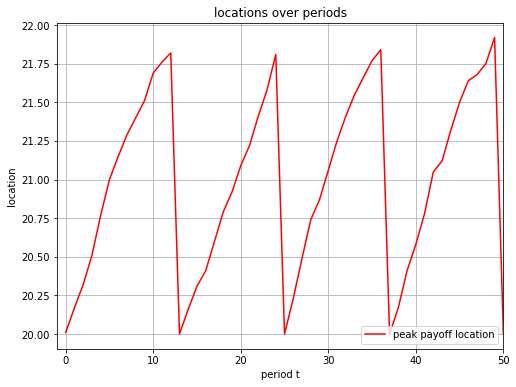

In [8]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1, 1)
ax5 = fig.add_subplot(gs[0,0]) #locations over periods

# ax5.plot(history_round, history_max_location, label='max location', c='b')
ax5.plot(history_round, history_peak_payoff_location, label='peak payoff location', c='r')
# ax5.plot(history_round, history_mean_location, label='avg location', c='black')
# ax5.plot(history_round, history_min_location, label='min location', c='orange')
ax5.set_xlim([-1, history_round[-1]])
#         ax5.set_ylim([8,16])
ax5.set_xlabel('period t')
ax5.set_ylabel('location')
ax5.set_title('locations over periods')
ax5.grid(visible=True)
ax5.legend(loc='lower right')
plt.show()

----------------Simulation Start----------------
Period 0 done
Period 20 done
Period 40 done
Period 60 done
Period 80 done
Period 100 done
Period 120 done
Period 140 done
Period 160 done
Period 180 done
Period 200 done
Period 220 done
Period 240 done
Period 260 done
Period 280 done
Period 300 done
Period 320 done
Period 340 done
Period 360 done
Period 380 done
Period 400 done
Period 420 done
Period 440 done
Period 460 done
Period 480 done
Period 500 done
Period 520 done
Period 540 done
Period 560 done
Period 580 done
Period 600 done
Period 620 done
Period 640 done
Period 660 done
Period 680 done
Period 700 done
Period 720 done
Period 740 done
Period 760 done
Period 780 done
Period 800 done
----------------Simulation End----------------
simulation spent time: 1:56:27.517812
----------------Plotting Start----------------


<IPython.core.display.Javascript object>


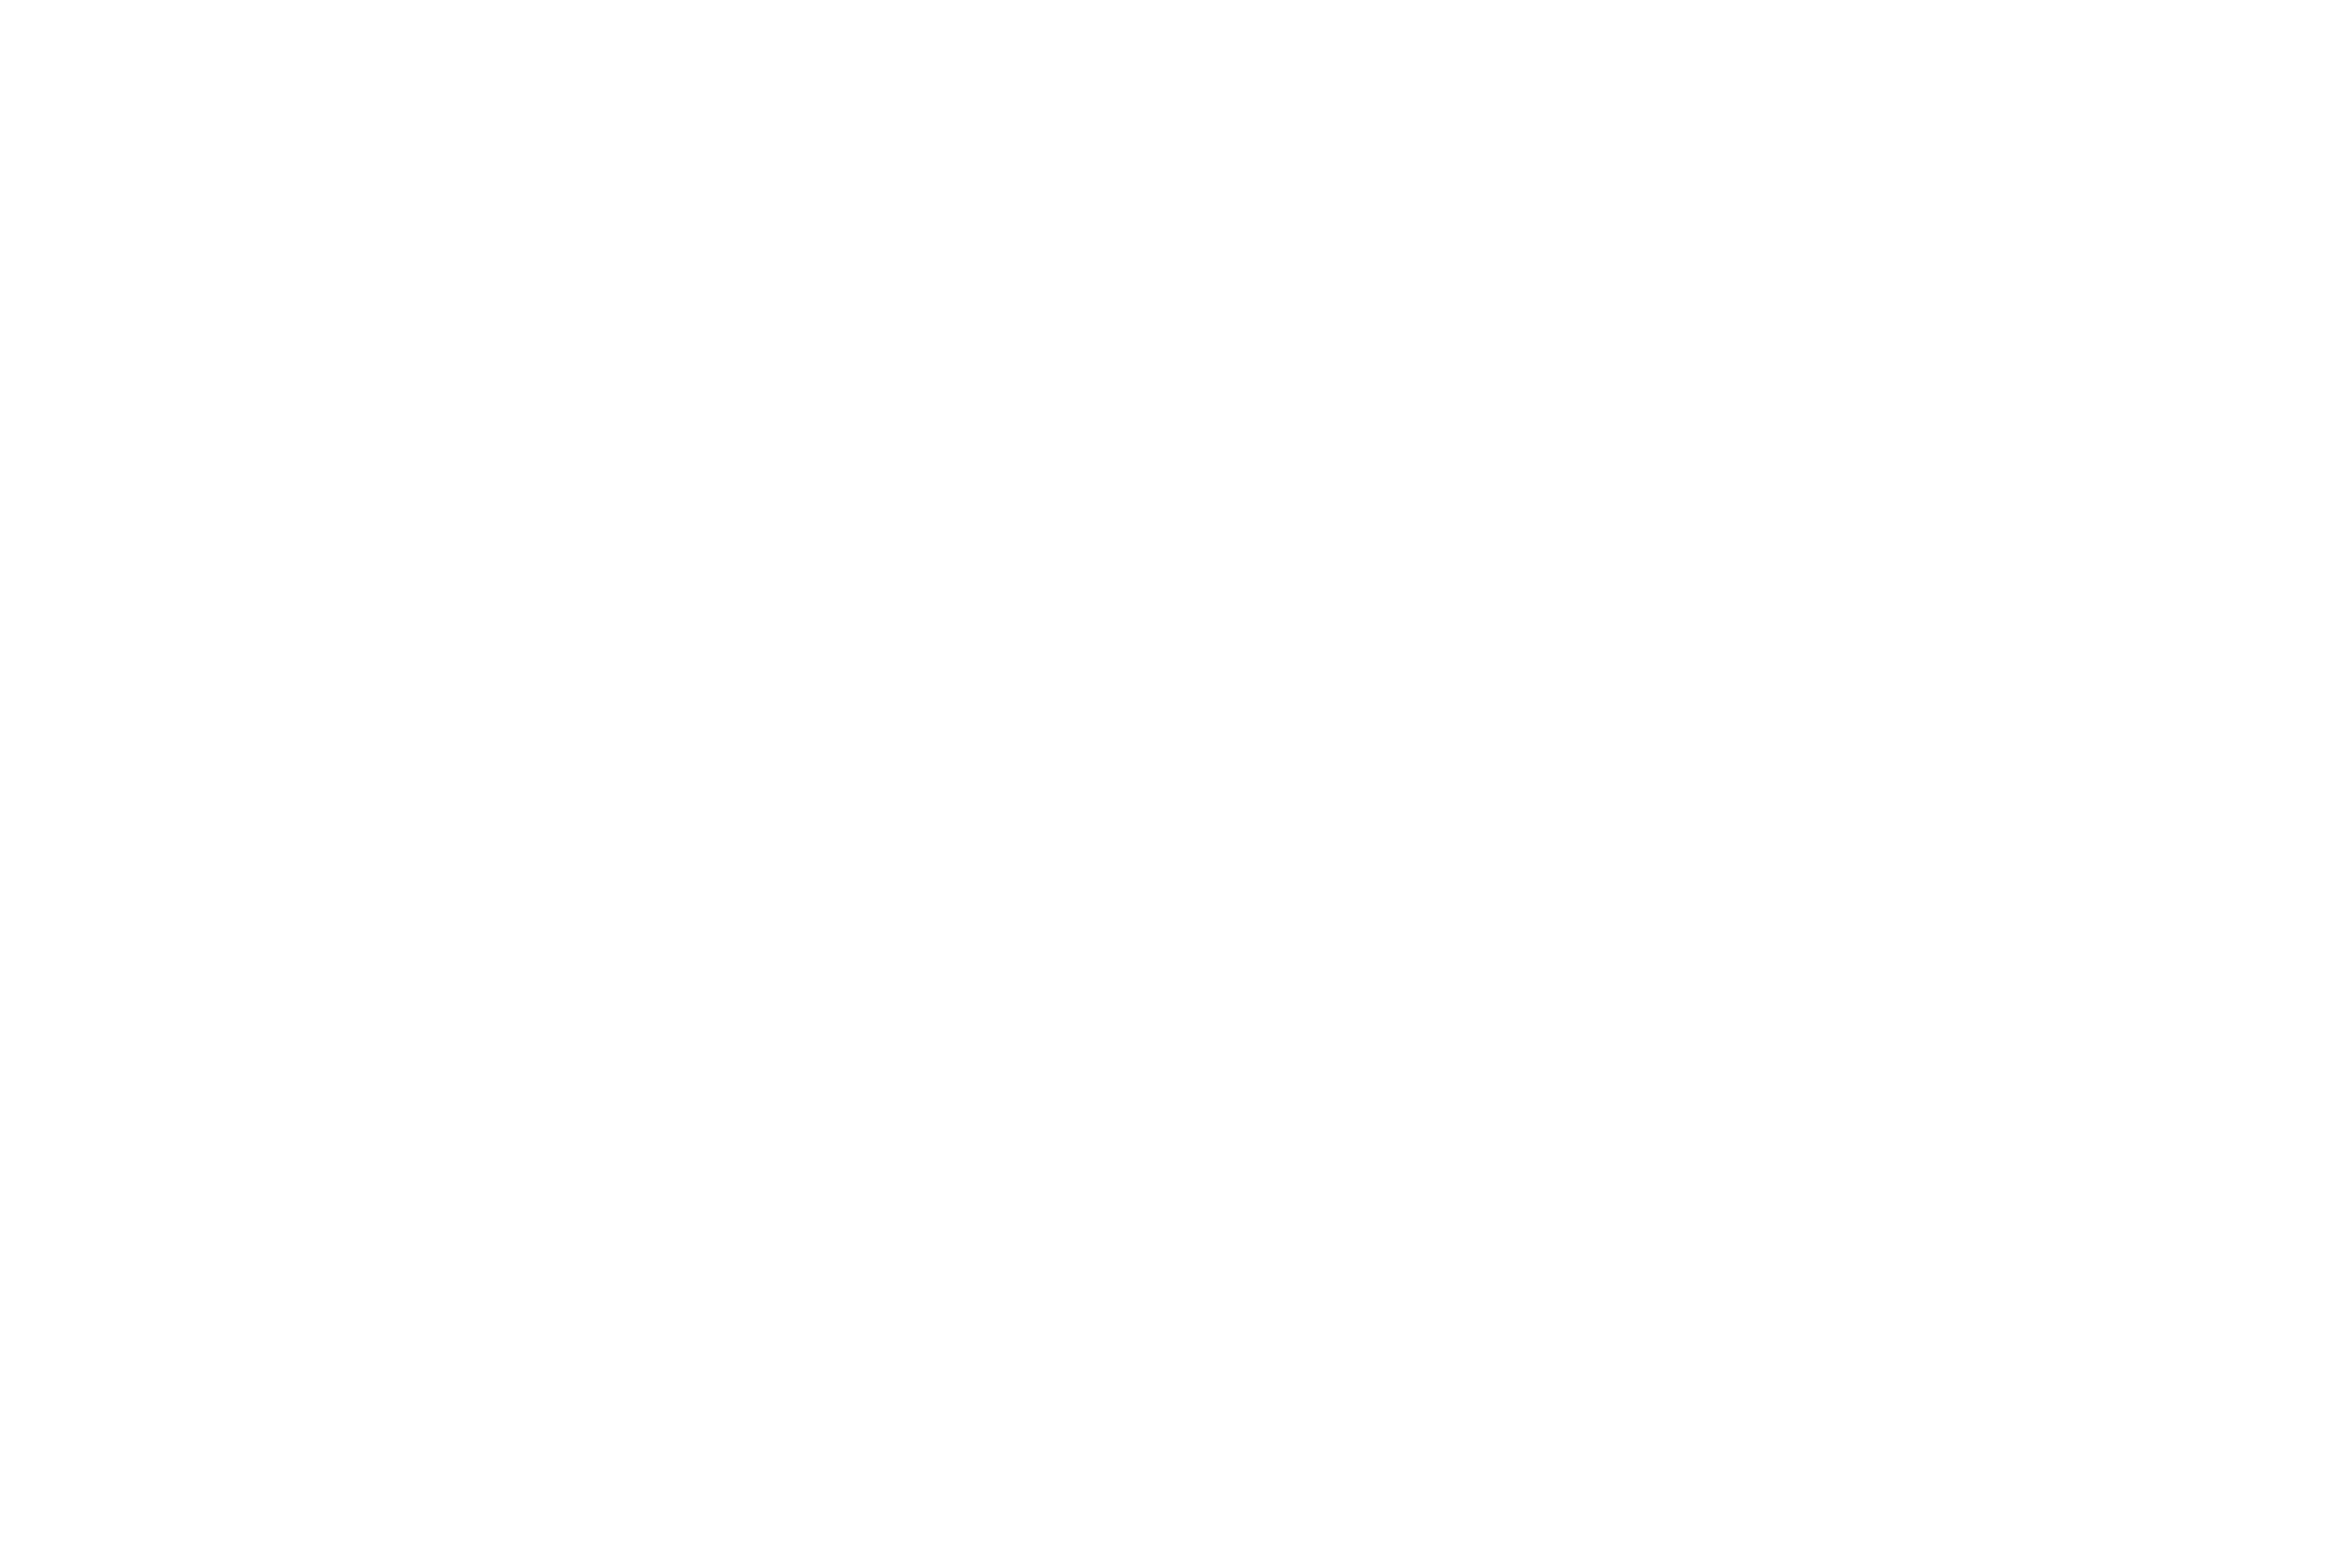

GIF saved as: ./April2024_sim_plots/1.1.6_greed_bots5000_leaving_random_move0.01_trembling_normal0.06/1.1.6_greed_bots5000_leaving_random_move0.01_trembling_normal0.06.gif
----------------Plotting End----------------
----------------Simulation Start----------------
Period 0 done
Period 20 done
Period 40 done
Period 60 done
Period 80 done
Period 100 done
Period 120 done
Period 140 done
Period 160 done
Period 180 done
Period 200 done
Period 220 done
Period 240 done
Period 260 done
Period 280 done
Period 300 done
Period 320 done
Period 340 done
Period 360 done
Period 380 done
Period 400 done
Period 420 done
Period 440 done
Period 460 done
Period 480 done
Period 500 done
----------------Simulation End----------------
simulation spent time: 1:12:48.417803
----------------Plotting Start----------------
GIF saved as: ./April2024_sim_plots/1.2.6_greed_bots5000_leaving_random_move0.05_trembling_normal0.06/1.2.6_greed_bots5000_leaving_random_move0.05_trembling_normal0.06.gif
----------------Plot

In [7]:
from datetime import datetime
from PIL import Image
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
%matplotlib notebook


main_folder = 'April2024_sim_plots/'
# para_folder = ['2.3.2_', '2.3.3_','2.3.4_','2.2.1_','2.2.2_','2.2.3_','2.2.4_', '2.1.1_','2.1.2_','2.1.4_']
# para_trembling = [0.1, 0.03, 0.01, 0.3, 0.1, 0.03, 0.01, 0.3, 0.1, 0.01]
# para_game_length = [300, 300, 600, 300, 300, 500, 800, 400, 600, 1000]
# para_move = [0.2, 0.2, 0.2, 0.05, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01]

# para_folder = ['2.4.1_', '2.4.2_', '2.4.3_','2.4.4_']
# para_trembling = [0.3, 0.1, 0.03, 0.01]
# para_game_length = [100, 100, 200, 300]
# para_move = [0.5,0.5, 0.5, 0.5]


# para_folder = ['3.1.1_','3.1.2_','3.1.4_','3.1.3_']
# para_trembling = [0.3, 0.1, 0.01, 0.03]
# para_game_length = [400, 600, 1000, 800]
# para_move = [0.01, 0.01,0.01,0.01]

# para_folder = ['2.1.3_']
# para_trembling = [0.03]
# para_game_length = [800]
# para_move = [0.01]

para_folder = ['1.1.6_', '1.2.6_', '1.3.6_', '1.4.6_']
para_trembling = [0.06, 0.06, 0.06, 0.06]
para_game_length = [800, 500, 300, 300]
para_move = [0.01, 0.05,0.2, 0.5]



for para in range(len(para_trembling)):
    start=datetime.now()
    history = {}
    round_idx = 0
    history_round = []
    history_peak_payoff_location = []
    history_peak_payoff_count = []
    history_max_location = []
    history_min_location = []
    history_mean_location = []
    history_median_location = []
    
    # Set up simulation configuration
    #####################################
    sim_config = sim_config_init(
        game_type= 'greed', 
        lgr=(10,5,2), 
        num_bots=5000, 
        game_length=para_game_length[para], 
        decimals = 2,
        initialization_dist = 'NE', #initialization, can be 'NE', 'NE_support', 'uniform', 'normal'
        initialization_range = (1,2), # if 'uniform' set the range; if 'normal', set mean and std
        move_percent = para_move[para], 
        trembling_dist='normal', #normal or None or uniform or triangular
        trembling_range=(0,para_trembling[para]), 
        leaving_function='random', #random or distance_proportional, distance_most_gain
        outlier_index_set=[],  
        payoff_multiplier=1, 
        payoff_deduction=0,
    )
    if sim_config['trembling_dist'] == 'normal':
        folder_name = para_folder[para] + 'greed_'+'bots'+str(sim_config['num_bots'])+'_leaving_' + sim_config['leaving_function'] + '_move'+ str(sim_config['move_percent'])+'_trembling_' + sim_config['trembling_dist'] + str(sim_config['trembling_range'][1]) + '/'
    elif sim_config['trembling_dist'] == 'None':
        folder_name = para_folder[para] + 'greed_'+'bots'+str(sim_config['num_bots'])+'_leaving_' + sim_config['leaving_function'] + '_move'+ str(sim_config['move_percent'])+'_trembling_' + sim_config['trembling_dist'] + '/'
    # NE support
    NE_support_min = sim_config['NE_support_min']
    NE_support_max = sim_config['NE_support_max']


    print('----------------Simulation Start----------------')
    # Simulate players' initial strategies and payoffs
    strategies,initial_strategies = initialize_strategies(sim_config)
    x, y, quantile, bubble = calculate_payoff(sim_config, strategies)
    # find the peak payoff location
    peak_payoff = max(y)
    peak_payoff_count = np.count_nonzero(y == peak_payoff)
    indice = np.where(y == peak_payoff)[0]
    peak_payoff_location = x[indice][0]
    # print(indice, peak_payoff_location)


    # Log data for the initial round
    history['strategies', round_idx] = np.array(strategies.copy())
    history['x', round_idx] = x
    history['y', round_idx] = y
    history['quantile', round_idx] = quantile
    history['bubble', round_idx] = bubble
    history['selected_player_index', round_idx] = None
    history['peak_payoff_location', round_idx] = peak_payoff_location
    history['peak_payoff', round_idx] = peak_payoff


    history_round.append(round_idx)
    history_peak_payoff_location.append(peak_payoff_location)
    history_peak_payoff_count.append(peak_payoff_count) #robustness check for one peak payoff location
    history_max_location.append(history['strategies', round_idx].max())
    history_min_location.append(history['strategies', round_idx].min())
    history_mean_location.append(history['strategies', round_idx].mean())
    history_median_location.append(np.median(history['strategies', round_idx]))


    # best response to next period is the peak payoff location with a noise
    # if sim_config['trembling_dist'] == 'normal':
    #     history['best_response_locations', round_idx] = np.round(peak_payoff_location + np.random.normal(sim_config['trembling_range'][0], sim_config['trembling_range'][1], sim_config['num_bots']),2)
    # elif sim_config['trembling_dist'] == 'uniform':
    #     history['best_response_locations', round_idx] = np.round(peak_payoff_location + np.random.uniform(sim_config['trembling_range'][0],sim_config['trembling_range'][0],sim_config['num_bots']),2)
    print('Period 0 done')

    # Iterate simulation to update players' strategies and payoff
    max_game_length = sim_config['game_length']

    while round_idx < max_game_length:
        round_idx += 1
        strategies, selected_player_index = update_strategies_unpurified(x, y, strategies,bubble, sim_config)
        x, y, quantile, bubble = calculate_payoff(sim_config, strategies)

        # find the peak payoff location
        peak_payoff = max(y)
        peak_payoff_count = np.count_nonzero(y == peak_payoff)
        indice = np.where(y == peak_payoff)[0]
        peak_payoff_location = x[indice][0]


        # Log data for the round
        history['strategies', round_idx] = np.array(strategies.copy())
        history['x', round_idx] = x
        history['y', round_idx] = y
        history['quantile', round_idx] = quantile
        history['selected_player_index', round_idx] = selected_player_index
        history['bubble', round_idx] = bubble
        history['peak_payoff_location', round_idx] = peak_payoff_location
        history['peak_payoff', round_idx] = peak_payoff


        history_round.append(round_idx)
        history_peak_payoff_location.append(peak_payoff_location)
        history_peak_payoff_count.append(peak_payoff_count) #robustness check for one peak payoff location
        history_max_location.append(history['strategies', round_idx].max())
        history_min_location.append(history['strategies', round_idx].min())
        history_mean_location.append(history['strategies', round_idx].mean())
        history_median_location.append(np.median(history['strategies', round_idx]))

        if round_idx%20 == 0:
            print('Period {} done'.format(round_idx))
            
    ##save parameters and history data
    history['game_type'] = sim_config['game_type']
    history['num_bots'] = sim_config['num_bots']
    history['game_length'] = sim_config['game_length']
    history['lambda'] = sim_config['lambda']
    history['gamma'] = sim_config['gamma']
    history['rho'] = sim_config['rho']
    history['move_percent'] = sim_config['move_percent']
    history['trembling_dist'] = sim_config['trembling_dist']
    history['trembling_range'] = sim_config['trembling_range']
    history['leaving_function'] = sim_config['leaving_function']
    
    history['history_round'] = history_round
    history['history_peak_payoff_location'] = history_peak_payoff_location
    history['history_max_location'] = history_max_location
    history['history_min_location'] = history_min_location
    history['history_mean_location'] = history_mean_location
    history['history_median_location'] = history_median_location
    
    # Save dictionary to a file using Pickle
    with open(para_folder[para] + 'data.pickle', 'wb') as f:
        pickle.dump(history, f)
        
    print('----------------Simulation End----------------')
    print('simulation spent time: {}'.format(datetime.now()-start))

    
    #########################plotting##########################
    print('----------------Plotting Start----------------')
    if sim_config['trembling_range'][1] > 0.2:
        binwid = 0.02
    else: 
        binwid = 0.01
    width = 0.05
    for selected_rd in range(sim_config['game_length']):
        fig = plt.figure(figsize=(15,10))
        gs = fig.add_gridspec(2, 3)
        ax1 = fig.add_subplot(gs[0, 0]) #landscape
        ax2 = fig.add_subplot(gs[1, 0]) #cdf
        ax3 = fig.add_subplot(gs[0, 1]) #histogram of location at t
        ax4 = fig.add_subplot(gs[0, 2]) #histogram of location at t+1
        ax5 = fig.add_subplot(gs[1, 1:]) #locations over periods
 

        ax1.plot(history['x', selected_rd], history['y', selected_rd], alpha=0.5, linewidth = '2', c='b', label='landscape')
        graph = ax1.scatter(history['strategies', selected_rd], history['bubble', selected_rd],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
        ax1.axvline(x=history['peak_payoff_location', selected_rd], color='r', linestyle='-',linewidth=1, label='peak payoff location')
        ax1.set_xlabel('location x')
        ax1.set_ylabel('Payoff')
        ax1.set_title('payoff')
        ax1.set_xlim([8,16])
        ax1.set_ylim([80, 130])
        ax1.grid(visible=True)


        vertical_value = history['peak_payoff_location', selected_rd]

        ax2.plot(history['x', 0], history['quantile', 0], label='NE cdf', c='orange', alpha=0.6)
        ax2.plot(history['x', selected_rd], history['quantile', selected_rd], linewidth = '2', c='b', alpha=0.6)
        ax2.axvline(x=history['peak_payoff_location', selected_rd], color='r', linestyle='-')
        ax2.set_xlabel('location x')
        ax2.set_ylabel('Quantile')
        ax2.set_title('cdf')
        ax2.grid(visible=True)
        ax2.set_xlim([8,16])
        ax2.legend(loc='upper left')



        sns.histplot(history['strategies', selected_rd],ax=ax3, binwidth=binwid, kde=True, stat='proportion', color='blue', label='hist and kernel density')
        ax3.axvline(x=history['peak_payoff_location', selected_rd], color='r', linestyle='-',linewidth=1, label='peak payoff location', zorder=1)
        ax3.set_xlim([min(history['strategies', selected_rd].min(),history['peak_payoff_location', selected_rd]) - width,history['strategies', selected_rd].max()+width])
        ax3.grid(visible=True)
        ax3.text(vertical_value + 0.02, ax3.get_ylim()[1] * 0.9, f'x = {vertical_value}', color='r')
        ax3.set_xlabel('location x')
        ax3.set_title('location at t')
        ax3.set_ylabel('density')
        

        sns.histplot(history['strategies', selected_rd+1],ax=ax4, binwidth=binwid, kde=True, stat='proportion', color='green')
        ax4.axvline(x=history['peak_payoff_location', selected_rd], color='r', linestyle='-',linewidth=1, label='peak payoff location at t', zorder=1)
        ax4.set_xlim([min(history['strategies', selected_rd+1].min(),history['peak_payoff_location', selected_rd])- width,history['strategies', selected_rd+1].max()+width])
        ax4.grid(visible=True)
        ax4.set_xlabel('location x')
        ax4.set_ylabel('density')
        ax4.set_title('location at t+1')
        ax4.legend(loc='upper right')

        for rd in range(selected_rd):
            plot_round = np.array([rd]*len(history['strategies', 0])) 
            ax5.plot(plot_round, history['strategies', rd], 'go', fillstyle='none', alpha=0.1, zorder=1)
        #     for outlier in range(len(sim_config['outlier_index_set'])):
        #         ax[1,:].plot(plot_round[sim_config['outlier_index_set'][outlier]], history['strategies', rd][sim_config['outlier_index_set'][outlier]],color=outlier_color_set[outlier], marker='o', alpha=0.2, zorder=2) 
        ax5.plot(history_round, history_max_location, label='max location', c='b')
        ax5.plot(history_round, history_peak_payoff_location, label='peak payoff location', c='r')
        ax5.plot(history_round, history_mean_location, label='avg location', c='black')
        ax5.plot(history_round, history_min_location, label='min location', c='orange')
        ax5.set_xlim([-1, history_round[-1]])
        ax5.set_ylim([8,16])
        ax5.set_xlabel('period t')
        ax5.set_ylabel('location')
        ax5.set_title('locations over periods')
        ax5.grid(visible=True)
        ax5.legend(loc='lower right')
        
        if sim_config['trembling_dist'] == 'normal':
            if sim_config['leaving_function'] == 'distance_most_gain':
                parameters = 'Bots:'+str(sim_config['num_bots'])+'; Leaving Formula: players with most gain; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: ' + sim_config['trembling_dist'] + ' N(0,'+ str(round(sim_config['trembling_range'][1]**2, 4)) + ')'
            elif sim_config['leaving_function'] == 'distance_proportional':
                parameters = 'Bots:'+str(sim_config['num_bots'])+'; Leaving Formula: players with more gain are more likely to move; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: ' + sim_config['trembling_dist'] + ' N(0,'+ str(round(sim_config['trembling_range'][1]**2, 4)) + ')'
            elif sim_config['leaving_function'] == 'random':    
                parameters = 'Bots:'+str(sim_config['num_bots'])+'; Leaving Formula: ' + sim_config['leaving_function'] + '; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: ' + sim_config['trembling_dist'] + ' N(0,'+ str(round(sim_config['trembling_range'][1]**2, 4)) + ')'
        
        elif sim_config['trembling_dist'] == 'None':
            if sim_config['leaving_function'] == 'distance_most_gain':
                parameters = 'Bots:'+str(sim_config['num_bots'])+'; Leaving Formula: players with most gain; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: None'
            elif sim_config['leaving_function'] == 'distance_proportional':
                parameters = 'Bots:'+str(sim_config['num_bots'])+'; Leaving Formula: players with more gain are more likely to move; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: None'
            elif sim_config['leaving_function'] == 'random':    
                parameters = 'Bots:'+str(sim_config['num_bots'])+'; Leaving Formula: ' + sim_config['leaving_function'] + '; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: None'

        ax1.text(0.2, 1.2, parameters, transform=ax1.transAxes,fontsize = 12)
        ax1.text(0.2, 1.1, 'sim: '+sim_config['game_type'] + ' (lambda, gamma, rho) = '+ '(' + str(sim_config['lambda']) + ', ' + str(sim_config['gamma']) + ', ' + str(sim_config['rho']) + ')'+ ': Period ' + str(selected_rd), transform=ax1.transAxes,fontsize = 14)

        file_name = folder_name[:-1] +'_'+ str(selected_rd)+ '.png'
        plt.savefig('./'+main_folder + folder_name + file_name, dpi=fig.dpi, bbox_inches='tight')
        plt.ioff()
        plt.close()
        
    
    png_files = [] #save for pngs
    for i in range(sim_config['game_length']):
        file_name = folder_name[:-1] +'_'+str(i)+'.png'
    # List of PNG image filenames
        png_files.append(file_name)
    # Open the PNG images and convert them to GIF
    images = [Image.open('./'+main_folder + folder_name +filename) for filename in png_files]

    # Save the GIF file
    gif_filename = './'+main_folder+ folder_name +folder_name[:-1]+'.gif'
    images[0].save(gif_filename, save_all=True, append_images=images[1:], loop=0, duration=100)

    print("GIF saved as:", gif_filename)
    
    
    #Second plot: difference between hat(F(L)) and F(L) over location
    history_diff_cdf = []
    for i in range(sim_config['game_length']):
        peak_location = history['peak_payoff_location', i]
        freq_t = np.count_nonzero(np.round(history['strategies', i],2) <= peak_location) # the frequency of locations that are lower or equal to peak location
        freq_t_plus1 = np.count_nonzero(np.round(history['strategies', i+1],2) <= peak_location)
        cdf_t = freq_t/len(history['strategies', i])
        cdf_t_plus1 = freq_t_plus1/len(history['strategies', i])
        diff_cdf = cdf_t_plus1 - cdf_t
        history_diff_cdf.append(diff_cdf)

    plt.figure(figsize=(8,6))
    plt.plot(history_peak_payoff_location[:-1], history_diff_cdf, 'bo', fillstyle='none', alpha=0.5)
    plt.axhline(y=0, color='g')
    plt.ylabel('hat(F(L)) - F(L)')
    plt.xlabel('location x')
    plt.title('hat(F(L)) - F(L) over location')
    plt.grid()  
    plt.savefig('./'+main_folder + folder_name + para_folder[para] + 'cdf_diff_over_location.png', dpi=fig.dpi, bbox_inches='tight')
    plt.ioff()
    plt.close()
    
    #Third plot: difference between hat(F(L)) and F(L) over time
    plt.figure(figsize=(8,6))
    plt.plot(history_round[:-1], history_diff_cdf,'ro', fillstyle='none', alpha=0.5)
    plt.axhline(y=0, color='g')
    plt.ylabel('hat(F(L)) - F(L)')
    plt.xlabel('period t')
    plt.title('hat(F(L)) - F(L) over time')
    plt.grid()  
    plt.savefig('./'+main_folder + folder_name + para_folder[para] + 'cdf_diff_over_time.png', dpi=fig.dpi, bbox_inches='tight')
    plt.ioff()
    plt.close()
    print('----------------Plotting End----------------')


In [29]:
import pickle

# Open the .pickle file for reading in binary mode
with open('./April2024_sim_plots/2.1.1_data.pickle', 'rb') as f:
    # Load the data from the file
    data = pickle.load(f)
    
history_mover_from_left_fraction = []
for rd_idx in range(data['game_length']):
    mover_from_left_set = [data['strategies', rd_idx][player_idx] for player_idx in data['selected_player_index',rd_idx+1]]
    history_mover_from_left_fraction.append(len(mover_from_left_set))

In [16]:
# continue to run

while round_idx < 800:
    round_idx += 1
    strategies, selected_player_index = update_strategies_unpurified(x, y, strategies,bubble, sim_config)
    x, y, quantile, bubble = calculate_payoff(sim_config, strategies)
    
    # find the peak payoff location
    peak_payoff = max(y)
    peak_payoff_count = np.count_nonzero(y == peak_payoff)
    indice = np.where(y == peak_payoff)[0]
    peak_payoff_location = x[indice][0]


    # Log data for the round
    history['strategies', round_idx] = np.array(strategies.copy())
    history['x', round_idx] = x
    history['y', round_idx] = y
    history['quantile', round_idx] = quantile
    history['selected_player_index', round_idx] = selected_player_index
    history['bubble', round_idx] = bubble
    history['peak_payoff_location', round_idx] = peak_payoff_location
    history['peak_payoff', round_idx] = peak_payoff


    history_round.append(round_idx)
    history_peak_payoff_location.append(peak_payoff_location)
    history_peak_payoff_count.append(peak_payoff_count) #robustness check for one peak payoff location
    history_max_location.append(history['strategies', round_idx].max())
    history_min_location.append(history['strategies', round_idx].min())
    history_mean_location.append(history['strategies', round_idx].mean())
    

#     # best response to next period is the peak payoff location with a noise
#     if sim_config['trembling_dist'] == 'normal':
#         history['best_response_locations', round_idx] = np.round(peak_payoff_location + np.random.normal(sim_config['trembling_range'][0], sim_config['trembling_range'][1], sim_config['num_bots']),2)
#     elif sim_config['trembling_dist'] == 'uniform':
#         history['best_response_locations', round_idx] = np.round(peak_payoff_location + np.random.uniform(sim_config['trembling_range'][0],sim_config['trembling_range'][0],sim_config['num_bots']),2)

    if round_idx%20 == 0:
        print('Period {} done'.format(round_idx))


Period 520 done
Period 540 done
Period 560 done
Period 580 done
Period 600 done
Period 620 done
Period 640 done
Period 660 done
Period 680 done
Period 700 done
Period 720 done
Period 740 done
Period 760 done
Period 780 done
Period 800 done


<IPython.core.display.Javascript object>


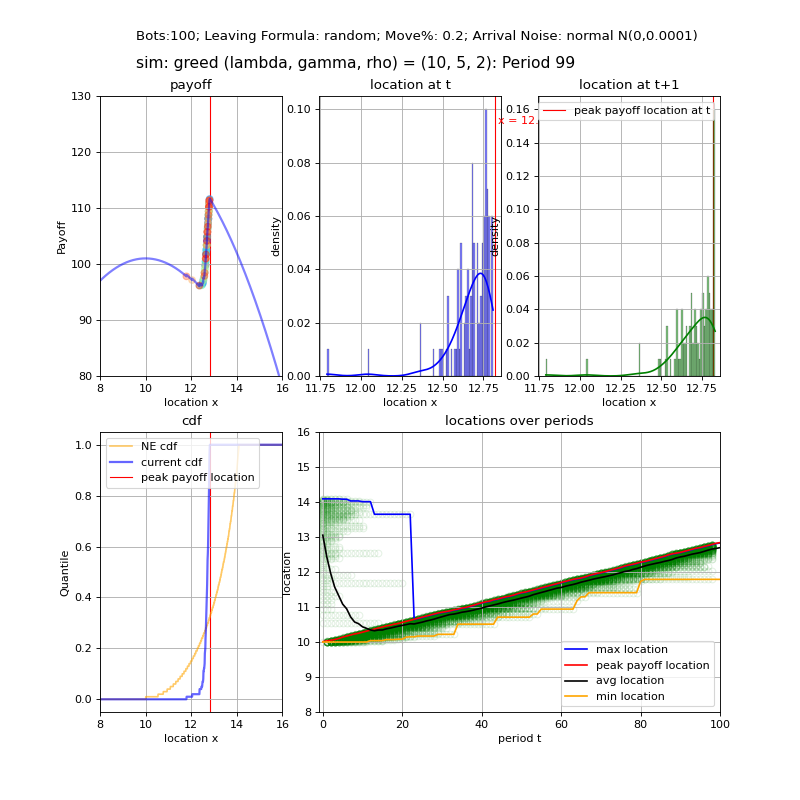

Done


In [22]:
#selected round
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

binwid = 0.01
width = 0.05
# if sim_config['trembling_range'][1] == 0.02:
#     binwid = 0.01
#     width = 0.05
# elif sim_config['trembling_range'][1] == 0.1:
#     binwid = 0.05
#     width = 0.5
# else:
#     binwid = 0.02
#     width = 0.2
# png_files = [] #save for pngs
# for selected_rd in range(0,800):
for selected_rd in range(99,100):
# selected_rd=6
# print(history['strategies', selected_rd],history['bubble', selected_rd])
#     fig, ax = plt.subplots(3,2, figsize=(10, 15))
    
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(2, 3)
#     fig = plt.figure(figsize=(10,10))
#     gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1])
#     ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[0, 2])
    ax5 = fig.add_subplot(gs[1, 1:])
#     ax5 = fig.add_subplot(gs[1, :])

    ax1.plot(history['x', selected_rd], history['y', selected_rd], alpha=0.5, linewidth = '2', c='b', label='landscape')
    # ax[0,0].axhline(avg_NE_payoff, color='r', linestyle='-', label='NE payoff')
    graph = ax1.scatter(history['strategies', selected_rd], history['bubble', selected_rd],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.4)
    ax1.axvline(x=history['peak_payoff_location', selected_rd], color='r', linestyle='-',linewidth=1, label='peak payoff location', zorder=0)
    ax1.set_xlabel('location x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
#     ax1.text(vertical_value + 0.02, ax1.get_ylim()[1] * 0.9, f'x = {vertical_value}', color='r')
    ax1.set_xlim([8,16])
    ax1.set_ylim([80, 130])
    #     ax[0,0].set_ylim(ymin=0)
    ax1.grid(visible=True)
#     ax[0,0].legend()

    vertical_value = history['peak_payoff_location', selected_rd]

    #     ax2.clear()
    ax2.plot(history['x', 0], history['quantile', 0], label='NE cdf', c='orange', alpha=0.6)
    ax2.plot(history['x', selected_rd], history['quantile', selected_rd], linewidth = '2', label='current cdf', c='b', alpha=0.6)
    #     ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf', c='orange')
    # ax[0,1].plot(strategies_cdf, cdf, label='Nash eqm cdf', c='g')
    ax2.axvline(x=history['peak_payoff_location', selected_rd], color='r', linestyle='-',linewidth=1, label='peak payoff location', zorder=0)
    ax2.set_xlabel('location x')
    ax2.set_ylabel('Quantile')
    ax2.set_title('cdf')
    ax2.grid(visible=True)
    ax2.set_xlim([8,16])
    ax2.legend(loc='upper left')
#     ax[0,1].legend()
    #     ax2.legend(('current cdf', 'NE cdf'))

    
#     density_ylim = stats.mode(history['strategies', selected_rd], keepdims=False)[0]/5000 + 0.002
    #     sns.ecdfplot(history['strategies', i],ax=axes[1, 0], color='blue')
    sns.histplot(history['strategies', selected_rd],ax=ax3, binwidth=binwid, kde=True, stat='proportion', color='blue', label='hist and kernel density')
    ax3.axvline(x=history['peak_payoff_location', selected_rd], color='r', linestyle='-',linewidth=1, label='peak payoff location')
    ax3.set_xlim([history['strategies', selected_rd].min() - width,history['strategies', selected_rd].max()+width])
#     ax3.set_xlim([history['peak_payoff_location', selected_rd]-0.2,history['peak_payoff_location', selected_rd]+0.2])
#     ax3.set_ylim([0,density_ylim])
    ax3.grid(visible=True)
#     ax3.set_xticks(list(ax3.get_xticks()) + [history['peak_payoff_location', selected_rd]])
    ax3.text(vertical_value + 0.02, ax3.get_ylim()[1] * 0.9, f'x = {vertical_value}', color='r')
    ax3.set_xlabel('location x')
    ax3.set_title('location at t')
    ax3.set_ylabel('density')
#     ax[1,0].legend()

#     sns.histplot(history['best_response_locations', selected_rd],ax=ax[2, 0], binwidth=0.01, kde=True, stat='proportion', color='purple', label='hist and kernel density')
#     ax[2,0].axvline(x=history['peak_payoff_location', selected_rd], color='r', linestyle='-',linewidth=2, label='peak payoff location')
#     ax[2,0].set_xlim([history['best_response_locations', selected_rd].min()-0.5,history['best_response_locations', selected_rd].max()+0.5])
#     ax[2,0].grid(visible=True)
#     ax[2,0].set_ylim([0,0.2])
#     ax[2,0].set_title('best response location at t+1')
#     ax[2,0].set_xlabel('location x')
#     ax[2,0].set_ylabel('density')
#     ax[2,0].legend()
    
    sns.histplot(history['strategies', selected_rd+1],ax=ax4, binwidth=binwid, kde=True, stat='proportion', color='green')
    ax4.axvline(x=history['peak_payoff_location', selected_rd], color='r', linestyle='-',linewidth=1, label='peak payoff location at t', zorder=0)
    ax4.set_xlim([history['strategies', selected_rd].min() - width,history['strategies', selected_rd].max()+width])
#     ax4.set_xlim([history['peak_payoff_location', selected_rd]-0.2,history['peak_payoff_location', selected_rd]+0.2])
#     ax4.set_ylim([0,density_ylim])
    ax4.grid(visible=True)
#     ax4.text(vertical_value + 0.02, ax4.get_ylim()[1] * 0.9, f'x = {vertical_value}', color='r')
    ax4.set_xlabel('location x')
    ax4.set_ylabel('density')
    ax4.set_title('location at t+1')
    ax4.legend(loc='upper right')

    for rd in range(selected_rd):
        plot_round = np.array([rd]*len(history['strategies', 0])) 
        ax5.plot(plot_round, history['strategies', rd], 'go', fillstyle='none', alpha=0.1, zorder=1)
    #     for outlier in range(len(sim_config['outlier_index_set'])):
    #         ax[1,:].plot(plot_round[sim_config['outlier_index_set'][outlier]], history['strategies', rd][sim_config['outlier_index_set'][outlier]],color=outlier_color_set[outlier], marker='o', alpha=0.2, zorder=2) 
    ax5.plot(history_round, history_max_location, label='max location', c='b')
    ax5.plot(history_round, history_peak_payoff_location, label='peak payoff location', c='r')
    ax5.plot(history_round, history_mean_location, label='avg location', c='black')
    ax5.plot(history_round, history_min_location, label='min location', c='orange')
    ax5.set_xlim([-1, history_round[-1]])
    ax5.set_ylim([8,16])
    ax5.set_xlabel('period t')
    ax5.set_ylabel('location')
    ax5.set_title('locations over periods')
    ax5.grid(visible=True)
    ax5.legend(loc='lower right')
    
    if sim_config['leaving_function'] == 'distance_most_gain':
        parameters = 'Bots:'+str(sim_config['num_bots'])+'; Leaving Formula: players with most gain; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: ' + sim_config['trembling_dist'] + ' N(0,'+ str(round(sim_config['trembling_range'][1]**2, 4)) + ')'
    elif sim_config['leaving_function'] == 'distance_proportional':
        parameters = 'Bots:'+str(sim_config['num_bots'])+'; Leaving Formula: players with more gain are more likely to move; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: ' + sim_config['trembling_dist'] + ' N(0,'+ str(round(sim_config['trembling_range'][1]**2, 4)) + ')'
    elif sim_config['leaving_function'] == 'random':    
        parameters = 'Bots:'+str(sim_config['num_bots'])+'; Leaving Formula: ' + sim_config['leaving_function'] + '; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: ' + sim_config['trembling_dist'] + ' N(0,'+ str(round(sim_config['trembling_range'][1]**2, 4)) + ')'
    
#     parameters = 'Leaving Formula: ' + sim_config['leaving_function'] + '; Move%: '+ str(sim_config['move_percent']) + '; Arrival Noise: ' + sim_config['trembling_dist'] + ' N(0,'+ str(round(sim_config['trembling_range'][1]**2, 4)) + ')'
    ax1.text(0.2, 1.2, parameters, transform=ax1.transAxes,fontsize = 12)
    ax1.text(0.2, 1.1, 'sim: '+sim_config['game_type'] + ' (lambda, gamma, rho) = '+ '(' + str(sim_config['lambda']) + ', ' + str(sim_config['gamma']) + ', ' + str(sim_config['rho']) + ')'+ ': Period ' + str(selected_rd), transform=ax1.transAxes,fontsize = 14)
    #     fig.suptitle(game_type_specification + ' game: Period ' + str(i))
    #     fig.canvas.draw()
    # plt.savefig('1.7 period' + str(selected_rd)+ '.png', dpi=fig.dpi, bbox_inches='tight')
#     folder_name = '1.3.4_greed_'+'bots'+str(sim_config['num_bots'])+'_leaving_' + sim_config['leaving_function'] + '_move'+ str(sim_config['move_percent'])+'_trembling_' + sim_config['trembling_dist'] + str(sim_config['trembling_range'][1])
#     file_name = folder_name +'_'+ str(selected_rd)+ '.png'
#     plt.savefig('./April2024_sim_plots/'+ folder_name + '/'+file_name, dpi=fig.dpi, bbox_inches='tight')
#     plt.ioff()
#     plt.close()
#     png_files.append(file_name)   
print('Done')

<IPython.core.display.Javascript object>


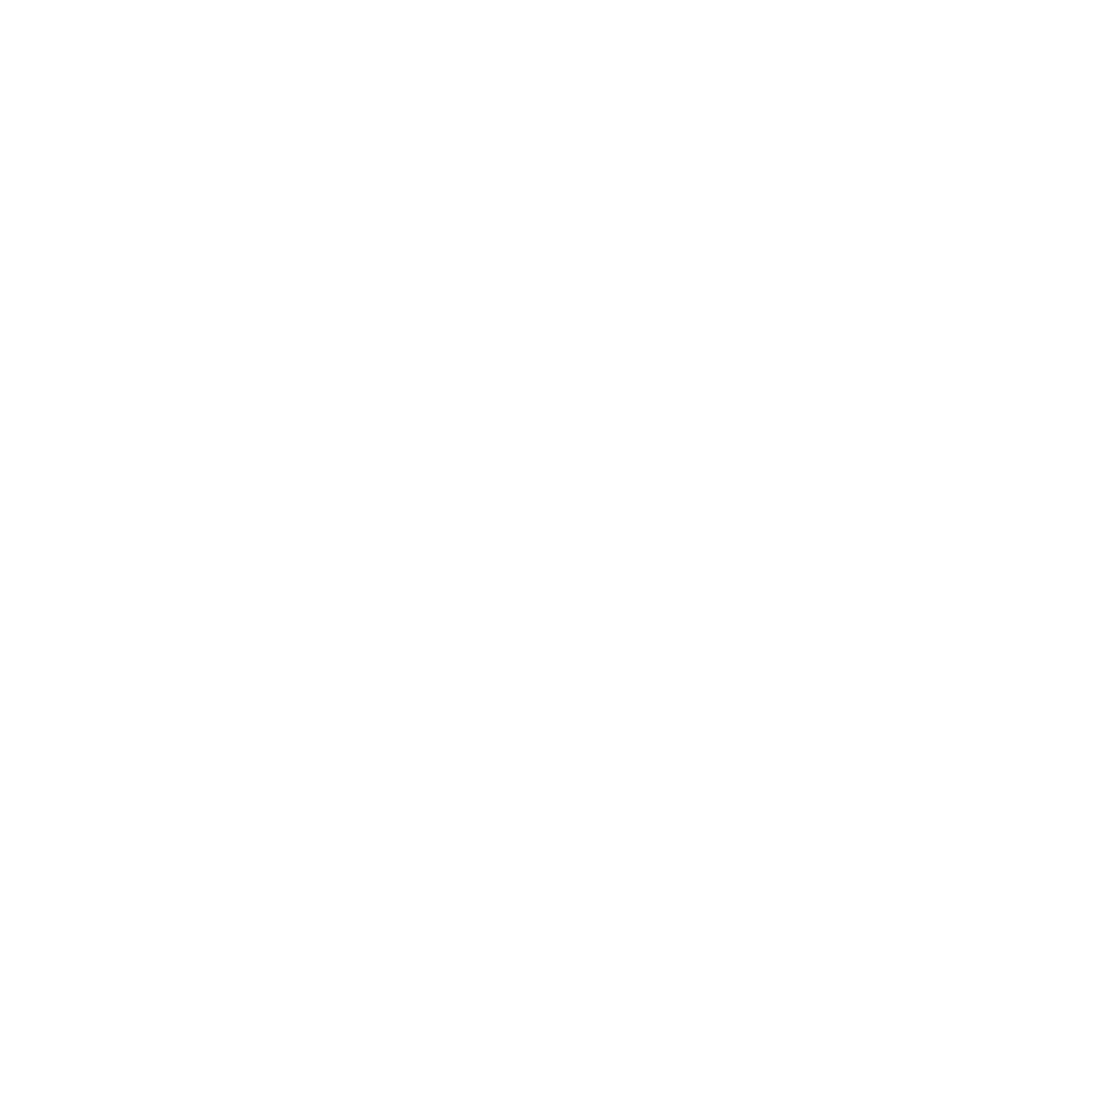

/var/folders/15/djmbdtz95_34fcrr8nrcvk_40000gn/T/ipykernel_31801/1280128138.py:58: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  images = [img.resize((width, height), Image.LANCZOS) for img in images]


GIF saved as: ./cycles/sim_data/simulation_for_experiment/fear_data_lam20_move80_noise0.05/fear_lgr_20_3.0_3_bots20_move0.8_leaving_random_trembling_normal0.05_scaled.gif


In [5]:
#generate gif
import os
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
%matplotlib notebook
main_folder = './cycles/sim_data/simulation_for_experiment/fear_data_lam20_move80_noise0.05/'
pickle_file = 'fear_lgr_20_3.0_3_bots20_move0.8_leaving_random_trembling_normal0.05.pickle'
payoff_deduction = 60
scale_rate= 0.2
# Open the .pickle file for reading in binary mode
with open(main_folder+pickle_file, 'rb') as f:
    # Load the data from the file
    data = pickle.load(f)
    
for selected_rd in range(len(data['history_round'])):
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0]) #landscape


    ax1.plot(data['x', selected_rd], data['y', selected_rd]*scale_rate-payoff_deduction, alpha=0.5, linewidth = '2', c='b', label='landscape')
    graph = ax1.scatter(data['strategies', selected_rd], np.array(data['bubble', selected_rd])*scale_rate-payoff_deduction,c = list(range(0,data['num_bots'])), cmap='rainbow', alpha=0.4)
    ax1.set_xlabel('location x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
    ax1.set_xlim([12, 22])
    ax1.set_ylim([0,25])
    ax1.grid()

    
    ax1.text(0.18, 1.1, 'sim: '+data['game_type'] + ' (lambda, gamma, rho) = '+ '(' + str(data['lambda']) + ', ' + str(data['gamma']) + ', ' + str(data['rho']) + ')'+ ': Period ' + str(selected_rd), transform=ax1.transAxes,fontsize = 12)

    file_name = pickle_file[:-7]+'_scaled' +'_'+ str(selected_rd)+ '.png'
    plt.savefig(main_folder + file_name, dpi=fig.dpi, bbox_inches='tight')
    plt.ioff()
    plt.close()


png_files = [] #save for pngs
for i in range(len(data['history_round'])):
    file_name = pickle_file[:-7]+'_scaled' +'_'+str(i)+'.png'
# List of PNG image filenames
    png_files.append(file_name)

# Open the PNG images and convert them to GIF
images = []
for filename in png_files:
    img_path = os.path.join(main_folder, filename)  # Construct full path
    img = Image.open(img_path).convert('RGBA')  # Ensure images are in RGBA format
    images.append(img)

# Resize images if necessary for consistency (optional)
# Example: Resize to the dimensions of the first image
if images:
    width, height = images[0].size
    images = [img.resize((width, height), Image.LANCZOS) for img in images]

# Save the GIF file
# gif_filename = os.path.join(main_folder, f"{pickle_file[:-7]}.gif") 
gif_filename = os.path.join(main_folder, f"{pickle_file[:-7]}_scaled.gif") 
images[0].save(gif_filename, save_all=True, append_images=images[1:], optimize=False,loop=0, duration=100)

print("GIF saved as:", gif_filename)